# English to Hindi Neural Machine Translation using Transformers
Neural networks for machine translation typically contains an `encoder` reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The `Transformer` starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire contexgt, represented by the filled balls, TGhis step is then repeated multiple times in parallel for all words, successively generating new representations

Let's break down the steps:
1. [Prepare the data](#1)
2. [Save and Load the data](#2)
2. [Implement the necessary components](#3) 
3. [Build & Train Transformer](#4)
4. [Generate Translations](#5)
5. [Export the model](#6)

In [34]:
# Imports
import sys
sys.path.append('../')

import scripts.PostionalEmbedding as pos_emb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from transformers import AutoTokenizer

<a name="1"></a>
## 1. Prepare the data

In [5]:
raw_data = pd.read_csv('../data/hindi_english_parallel.csv')
raw_data.head()

,hindi,english
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,Give your application an accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,Accerciser Accessibility Explorer
2,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the top panel
4,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...,A list of plugins that are disabled by default


In [6]:
raw_data.shape

(1561841, 2)

### 1.1 Checking null values

In [7]:
# Fraction of null values
raw_data.isna().sum()/raw_data.shape[0]

hindi      0.003877
english    0.000464
dtype: float64

In [8]:
# Let'e evaluate null values
raw_data[raw_data.english.isna()].head()

,hindi,english
241123,Comment,NaN
439613,को सीखने के लिए खुला रख पाएँ हो सकता है हम अपन...,NaN
446040,सर घुमाने के लिए जब भी कोई स्वर बदलता है-और हम...,NaN
481093,दरअसल वो गणना कर रहे होते हैं तब,NaN
497989,"शिशु सुनते हैं, जब",NaN


In [9]:
# Let's just remove null values 
raw_data.dropna(inplace=True)
raw_data.isna().sum()/raw_data.shape[0]

hindi      0.0
english    0.0
dtype: float64

### 1.2 Distribution of sentence lengths

In [10]:
def add_sent_len(data):
    # Hindi sentence
    data['hindi_sent_len'] = data['hindi'].apply(lambda x:len(x))
    # English sentence
    data['eng_sent_len'] = data['english'].apply(lambda x:len(x))
    
    # Few exampels
    print(data[['hindi_sent_len', 'eng_sent_len']].head())
    
    return data

In [11]:
raw_data = add_sent_len(raw_data)

   hindi_sent_len  eng_sent_len
0              47            46
1              31            33
2              37            46
3              36            43
4              65            46


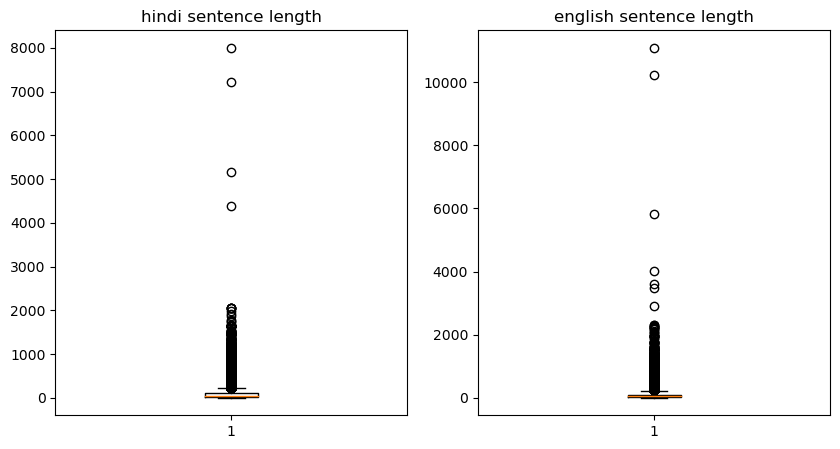

In [12]:
# Plot the distribution
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].set_title('hindi sentence length')
axs[0].boxplot(raw_data['hindi_sent_len'])
axs[1].set_title('english sentence length')
axs[1].boxplot(raw_data['eng_sent_len'])
plt.show()

we see some outliers for both hindi and english sentences 

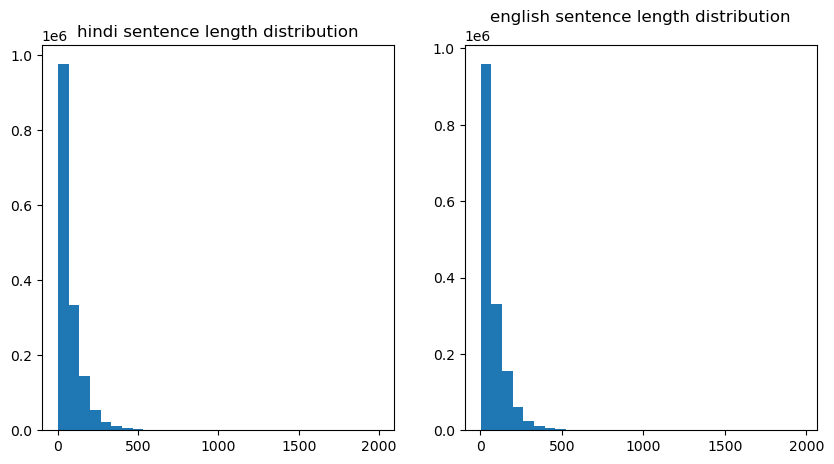

In [13]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].set_title('hindi sentence length distribution')
axs[0].hist(raw_data[raw_data['hindi_sent_len']<=2000]['hindi_sent_len'],bins=30)
axs[1].set_title('english sentence length distribution')
axs[1].hist(raw_data[raw_data['eng_sent_len']<=2000]['eng_sent_len'], bins=30)
plt.show()

We can see that majority of the sentence are covered by the sentence length of `500`, hence let's cap the sentence lenght to `500` for both hindi and english

In [14]:
raw_data[raw_data['hindi_sent_len']>2000].shape

(9, 4)

In [15]:
raw_data[raw_data['eng_sent_len']>2000].shape

(20, 4)

### 1.3 Training a Tokenizer

In [16]:
old_hin_tok = AutoTokenizer.from_pretrained('bert-base-cased')
old_eng_tok = AutoTokenizer.from_pretrained('bert-base-cased')

In [17]:
# Train tokenizer
def get_data(data, lang):
    # Getting 1000 rows of data in a single batch
    for i in range(0, len(data), 1000):
        yield data[lang].loc[i:i+1000]

In [18]:
# Train new tokenizer for hindi and english
hin_tok = old_hin_tok.train_new_from_iterator(get_data(raw_data, 'hindi'), 10000)
eng_tok = old_eng_tok.train_new_from_iterator(get_data(raw_data, 'english'), 10000)

### 1.4 Splitting the data into training, validation and testing

In [19]:
# Using 95% data for training and  validation and 5% for testing
train_split, test_split = train_test_split(raw_data, test_size=0.05, random_state=0)
train_split = train_split.reset_index(0).drop(labels=['index'], axis=1)
test_split = test_split.reset_index(0).drop(labels=['index'], axis=1)
train_split.shape, test_split.shape

((1477940, 4), (77787, 4))

In [20]:
# Using the train data to create train and validation set
train_split, val_split = train_test_split(train_split, test_size=0.05, random_state=0)
train_split = train_split.reset_index(0).drop(labels=['index'], axis=1)
val_split = val_split.reset_index(0).drop(labels=['index'], axis=1)
train_split.shape, val_split.shape

((1404043, 4), (73897, 4))

In [22]:
train_data = tf.data.Dataset.from_tensor_slices((train_split['english'], train_split['hindi']))
val_data = tf.data.Dataset.from_tensor_slices((train_split['english'], train_split['hindi']))

In [23]:
eng_examples, hin_examples = [], []
print('>Examples in English')
for eng,_ in train_data.take(5):
    print(eng.numpy().decode('utf-8'))
    eng_examples.append(eng)
print()
print('>Examples in Hindi')
for _, hin in train_data.take(5):
    print(hin.numpy().decode('utf-8'))
    hin_examples.append(hin)
eng_examples, hin_examples = tf.convert_to_tensor(eng_examples), tf.convert_to_tensor(hin_examples)

>Examples in English
Bharadwaj was chosen to represent mankind and he approached the gods.
The deep, dark green gave way to creamy white, almost as if an unseen hand had scattered confetti in the jungles.
Then, make sure to double check the breaker to ensure there is no voltage present
To add to Marandi 's woes, there is a growing desire among his ministers to live in plush bungalows and travel in air - conditioned cars.
expired accounts

>Examples in Hindi
ऋषि भारद्वाज को मानवजाति का प्रतिनिधि चुना गया और वे ईश-शरण में गए। 
वहां गहरे हरे रंग की जगह मखमली सफेद रंग छाया हा था, मानो पूरे जंगल में किसी ने कागज की कतरन बिखेर दी हो. 
तब, ब्रेकर कोई वोल्टेज मौजूद है सुनिश्चित करने के लिए डबल करने के लिए सुनिश्चित करें कि चेक करें 
मरांड़ी के जले पर नमक यह कि उनके मंत्रियों के मन में शानदार बंगलं में रहने और वातानुकूलित कारों में घूमने की ललसा बढेती जा रही है. 
कालातीत खाते


### 1.5 Encoding the data

In [24]:
print('>org hindi text')
for hin in hin_examples.numpy():
    print(hin.decode('utf-8'))
print()

# Tokenize the input
print('>Encoded text')
encodings = []
for hin in hin_examples.numpy():
    encode = hin_tok(hin.decode('utf-8')).input_ids
    print(encode)
    encodings.append(encode)
print()
# Detokenize the input
print('>Human readable text')
for enc in encodings:
    decoded = hin_tok.decode(enc)
    print(decoded)

>org hindi text
ऋषि भारद्वाज को मानवजाति का प्रतिनिधि चुना गया और वे ईश-शरण में गए। 
वहां गहरे हरे रंग की जगह मखमली सफेद रंग छाया हा था, मानो पूरे जंगल में किसी ने कागज की कतरन बिखेर दी हो. 
तब, ब्रेकर कोई वोल्टेज मौजूद है सुनिश्चित करने के लिए डबल करने के लिए सुनिश्चित करें कि चेक करें 
मरांड़ी के जले पर नमक यह कि उनके मंत्रियों के मन में शानदार बंगलं में रहने और वातानुकूलित कारों में घूमने की ललसा बढेती जा रही है. 
कालातीत खाते

>Encoded text
[2, 8254, 486, 974, 2314, 1113, 822, 1998, 5889, 826, 5655, 2860, 957, 813, 928, 288, 515, 17, 5994, 814, 1207, 366, 3]
[2, 2170, 6548, 5237, 1792, 820, 2058, 325, 494, 4271, 506, 5386, 1792, 6545, 1355, 934, 16, 4297, 2987, 6824, 814, 965, 878, 6075, 820, 6147, 8246, 8209, 1242, 1112, 832, 18, 3]
[2, 1433, 16, 7589, 905, 971, 2894, 876, 1901, 503, 2423, 807, 2967, 909, 809, 855, 313, 2255, 909, 809, 855, 2967, 993, 828, 5805, 993, 3]
[2, 6197, 9781, 506, 809, 1781, 493, 831, 7991, 891, 828, 983, 9276, 809, 1353, 814, 7139, 2554, 478, 480, 814, 

### 1.6 Setup a data pipeline with tf.data
The following function takes text inputs, and converts them into a format suitable for training:
1. It tokenizes the text
2. Trims the tokens to be no longer than MAX_TOKENS.

In [25]:
MAX_TOKENS = 128
def prepare_batch(eng, hin):
    #print(eng.numpy())
    #[print(e) for e in eng.numpy().decode('utf-8')]
    #eng = eng_tok(eng.numpy().decode('utf-8'),  padding=True, max_length=100, return_tensors='tf').input_ids[0]
    eng = eng_tok(eng.numpy().decode('utf-8'), return_tensors='tf').input_ids[0]
    eng = eng[:MAX_TOKENS]
    #eng = tf.convert_to_tensor(eng).to_tensor()
    
    #hin = [new_hin_tok(hin.numpy().decode('utf-8')).input_ids
    hin = hin_tok(hin.numpy().decode('utf-8'),return_tensors='tf').input_ids[0]
    # Separate target inputs and target outputs
    hin_inp = hin[:-1]
    hin_label = hin[1:]
    
    # padding
    eng = tf.concat([eng, [0]*(MAX_TOKENS - len(eng))], axis=0)
    hin_inp = tf.concat([hin_inp, [0]*(MAX_TOKENS - len(hin_inp))], axis=0)
    hin_label = tf.concat([hin_label, [0]*(MAX_TOKENS - len(hin_label))], axis=0)
    
    return eng, hin_inp, hin_label

In [26]:
# need to use tf.py_function as using .numpy() with map is not possible
# prefetch runs the dataset in parallel with the model to ensure that data is available when needed.
BATCH_SIZE = 64
train_batch = train_data.map(lambda eng, hin: tf.py_function(prepare_batch, [eng, hin], [tf.int32, tf.int32, tf.int32]),tf.data.AUTOTUNE)\
                        .batch(BATCH_SIZE)\
                        .prefetch(buffer_size = tf.data.AUTOTUNE)
val_batch = val_data.map(lambda eng, hin: tf.py_function(prepare_batch, [eng, hin], [tf.int32, tf.int32, tf.int32]),tf.data.AUTOTUNE)\
                        .batch(BATCH_SIZE)\
                        .prefetch(buffer_size = tf.data.AUTOTUNE)

In [46]:
for en, hin_inp, hin_label in train_batch.take(1):
    break
print('>Train batch dataset')
print(en.shape, hin_inp.shape, hin_label.shape)

print('>Valid batch dataset')
for en, hin_inp, hin_label in val_batch.take(1):
    break
print(en.shape, hin_inp.shape, hin_label.shape)

>Train batch dataset
(64, 128) (64, 128) (64, 128)
>Valid batch dataset
(64, 128) (64, 128) (64, 128)


<a name="2"></a>
## 2. Save the data

In [40]:
# Saving the data
tf.io.TFRecordWriter('../data/train_batch.tfrecord')
tf.io.TFRecordWriter('../data/val_batch.tfrecord')

In [48]:
# Load the data
train_batch = tf.data.TFRecordDataset('../data/train_batch.tfrecord')
val_batch = tf.data.TFRecordDataset('../data/val_batch.tfrecord')

In [49]:
for en, hin_inp, hin_label in t_batch.take(1):
    break
print('>Train batch dataset')
print(en.shape, hin_inp.shape, hin_label.shape)

print('>Valid batch dataset')
for en, hin_inp, hin_label in val_batch.take(1):
    break
print(en.shape, hin_inp.shape, hin_label.shape)

>Train batch dataset
(64, 128) (64, 128) (64, 128)
>Valid batch dataset
(64, 128) (64, 128) (64, 128)


<a name="3"></a>
## 3. Implement necessary components

<img src='../imgs/tfarchitecture.png' height="60%" width="60%"></img>
* Let's understand each component [img src](https://www.tensorflow.org/text/tutorials/transformer)

### 2.1 The embedding and positinal encoding layer
Given a sequence of tokens, both the input tokens (English) and target tokens (Hindi) have to be converted to vectors using a `tf.keras.layers.Embedding` layer. Since there are no recurrent/ convolution layers hence in order to maitain the word order.<br><br>
Formula used for calculating positional encoding(by definition nearby elements will have a similar position encoding):
* $PE_{pos,2i} = sin(pos/10000^{2i/d_{model}})$
* $PE_{pos,2i+1} = cos(pos/10000^{2i/d_{model}})$
<br>where $d_{model}$ refers to the depth of the model
* For better understanding watch the [video](https://www.youtube.com/watch?v=dichIcUZfOw)

In [50]:
def positional_encoding(length, depth):
    depth = depth/2
    
    positions = np.arange(length)[:,np.newaxis]    # (seq, 1)
    depths = np.arange(depth)[np.newaxis,:]/depth  # (1, depth)
    angle_rates = 1 / (10000**depths)              # (1, depth)
    angle_rads = positions*angle_rates             # (pos, depth)
    
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return pos_encoding

In [51]:
emb_hin = pos_emb.PositionalEmbedding(vocab_size=hin_tok.vocab_size, d_model=512)
emb_eng = pos_emb.PositionalEmbedding(vocab_size=eng_tok.vocab_size, d_model=512)

NameError: name 'positional_encoding' is not defined

In [35]:
hin_tok.vocab_size

10000

In [37]:
eng_tok.vocab_size()

TypeError: 'int' object is not callable

<a name="3"></a>
## 3. Build & Train the Transformer

<a name="4"></a>
## 4. Generate translations

<a name="5"></a>
## 5. Export the model